## Import libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px

## Import data from yfinance

Yfinance api provides flexibility and convenience for us to query stock price easily. Here we have pick up AAPL, which is our most famous stock, APPLE.


In [63]:
price_history = yf.Ticker('AAPL').history(period='5y', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                                   interval='1wk', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                   actions=False)

In [64]:
price_history.index = pd.to_datetime(price_history.index)

In [65]:
price_history[['Open']]

Open
Date                                 
2017-10-30 00:00:00-04:00   41.284343
2017-11-06 00:00:00-05:00   40.897596
2017-11-13 00:00:00-05:00   41.313692
2017-11-20 00:00:00-05:00   40.549331
2017-11-27 00:00:00-05:00   41.682786
...                               ...
2022-10-10 00:00:00-04:00  140.419998
2022-10-17 00:00:00-04:00  141.070007
2022-10-24 00:00:00-04:00  147.190002
2022-10-31 00:00:00-04:00  153.160004
2022-11-03 00:00:00-04:00  142.059998

[263 rows x 1 columns]

## Visualize tesla stock price

In [66]:
px.line(price_history[['Open','High','Low','Close']])

## Stationary Test
## Test I Augmented Dickey–Fuller (ADF) test

Null hypothesis: If failed to be rejected, it suggests the time series is not stationarity

Alternative hypothesis: The null hypothesis is rejected, it suggests the time series is stationary

In [67]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [68]:
adf_test(price_history[['Open']])

ADF Statistics: -0.825822
p-value: 0.811419
Critical values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


Since p-value > 0.05 (standard confidence interval), we cannot reject the null hypothesis. So the three time series are NOT stationary.

## Test II Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests

Null hypothesis: The time series is stationarity

Alternative hypothesis: The time series is non-stationary

In [69]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

In [70]:
print('KPSS Test: Apple time series')
kpss_test(price_history[['Open']])

KPSS Test: Apple time series
KPSS Statistic: 2.35075629290896
p-value: 0.01
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/Users/weinj/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Since p-value < 0.05 (standard confidence interval), we can reject the null hypothesis. So the time series is NOT stationary.

## ACF and PACF

ACF gives us values of auto-correlation of any series with its lagged values. I.e. The value of ACF at lag t is pearson correlation of time series itself and time series with lag t.
PACF gives us the correlation between time series itself and time series with lag t, BUT ignoring all the effect from lag t-1 to 0.

Other than having better understanding on time series, ACF and PACF are particularly useful when we choose the parameter of SARIMAX family in forecasting time series.
- ACF -> MA model
- PACF -> AR model

Anything within the blue band is not statistically significant. Hence we should only pick the lag values when ACF/PACF is OUTSIDE of blue band when using SARIMAX model.

/Users/weinj/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



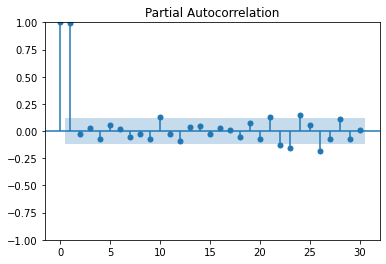

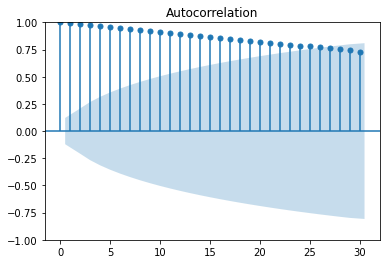

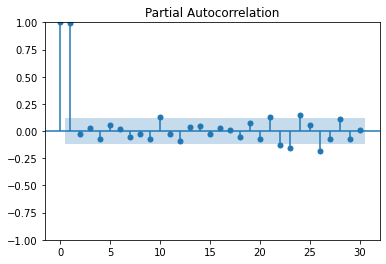

In [71]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(price_history[['Open']],lags = 30)
plot_pacf(price_history[['Open']],lags = 30)

To interpret the chart above, first we look at PACF chart. PACF chart tells us that value of this week is significantly affected by value last week, which makes sense in ACF chart as well. The ACF chart is smooth, this is because t week is affected by t-1 week, and t-1 week is affected by t-2 week...

Therefore, if we were to pick a base model for predicting this stock price, AR(1) could be our best first choice.

## Seasonal Trend Analysis

Every time series can be considered as composition of seasonal, trend and residuals. 

There are few parameters that are important to tune, which is model, and period.

1. Model

There are two possible models available in statsmodel library, which are 
    - addition model:
        $y(t) = s(t)+t(t)+r(t)$
    - multiplication model:
        $y(t) = s(t)*t(t)*r(t)$

The model type parameter can either be additive or multiplicative, this depends on if the amplitude of your data’s seasonality is level (mean) dependent. If the seasonality’s amplitude is independent of the level then you should use the additive model, and if the seasonality’s amplitude is dependent on the level then you should use the multiplicative model. -- Alex Mitrani

2. Period

(Purely from my opinion), this period refers to the period of each season pattern, i.e. how many parts would you like to split up the entire series into? (Assuming each part has the same season pattern)

From Alex Mitrani article, he suugested playing around with the period and find the most suitable one. I personally prefer to tune it such that the trend is more visible.

Choice of parameter: In our case, since the amplitude of volatility of AAPL stock price is not dependent on the trend, additive model is used. The choice of period is choose as 52 as 1 year has 52 week. This gives me a comprehensive view on how AAPL performs in four quarter.

In [77]:
import statsmodels.api as sm

In [78]:
decomposition = sm.tsa.seasonal_decompose(price_history[['Open']], model='additive',period = 52)

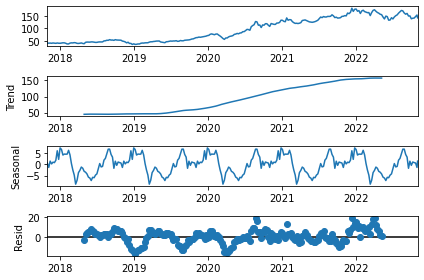

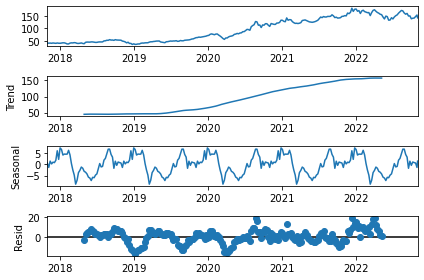

In [79]:
decomposition.plot()

As we expected, AAPL is performing well in these 5 years, as the stock price shows an increasing trend. From the seasonal chart, we can see that it's generally high in Q4, and low in Q1. Here we know when is our best timing to invest in AAPL stock! 😆

## Summary
In this notebook, we have showed what type of analysis can be applied to an univariate time series, which includes

- Stationary Test

- ACF, PACF to understand how lagged value is affect today's value. We can make uses of the lagged values to predict future flow.

- Seasonal Trend Analysis to understand how flows can be seperated into trend, seasons and noise.

## Reference

- https://towardsdatascience.com/time-series-diy-seasonal-decomposition-f0b469afed44
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
- https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
- https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Granger%20Causality%20Test.ipynb